<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#导入分词词典、停用词词典" data-toc-modified-id="导入分词词典、停用词词典-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>导入分词词典、停用词词典</a></span></li><li><span><a href="#导入文本数据并分词" data-toc-modified-id="导入文本数据并分词-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>导入文本数据并分词</a></span></li><li><span><a href="#主题个数选择：基于困惑度和一致性" data-toc-modified-id="主题个数选择：基于困惑度和一致性-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>主题个数选择：基于困惑度和一致性</a></span></li><li><span><a href="#lda结果可视化" data-toc-modified-id="lda结果可视化-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>lda结果可视化</a></span></li><li><span><a href="#困惑度-一致性" data-toc-modified-id="困惑度-一致性-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>困惑度 一致性</a></span><ul class="toc-item"><li><span><a href="#绘图" data-toc-modified-id="绘图-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>绘图</a></span></li></ul></li></ul></div>

以下代码来自于：https://gitee.com/kkkcuiya/examples-of-lda-model-application

In [1]:
import os
import csv
import jieba
import jieba.analyse
import pandas as pd
import warnings
warnings.filterwarnings('ignore') 

# 在gensim包中使用LDA
from gensim import corpora, models 
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

## 导入分词词典、停用词词典

In [2]:
# 载入自定义的分词词典
jieba.load_userdict(r'../stop_dic/user_dict.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\20866\AppData\Local\Temp\jieba.cache
Loading model cost 0.558 seconds.
Prefix dict has been built successfully.


In [3]:
# 读取停用词表并去重
def get_stop_words_set(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        return set([line.strip() for line in file])
# get_stop_words_set(r'../stop_dic/hit_stopwords.txt')

## 导入文本数据并分词

In [4]:
# 待分析数据去除停用词
def get_words_list(file_name, index, stop_word_file):
    '''
    file_name:待分析数据文件名
    index:待分析数据所在列
    stop_word_file:停用词文件名
    '''
    stop_words_set = get_stop_words_set(stop_word_file)
    print("共导入 %d 个停用词" % len(stop_words_set))

    word_list = []
    with open(file_name, 'r', encoding='utf-8', errors='ignore') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            tmp_list = list(jieba.cut(line[index - 1], cut_all=False))
            tmplist = []
            for tmp in tmp_list:
                tmplist.append(tmp.upper())
            word_list.append(
                [term for term in tmplist if str(term) not in stop_words_set])
    return word_list
# get_words_list(r'../data/TrainData_1.csv', 1, r'../stop_dic/hit_stopwords.txt')

In [5]:
# 文本列表，其中每个元素也是一个列表，即每行文字分词后形成的词语列表
word_list = get_words_list(r'../data/TrainData_1.csv', 1,  r'../stop_dic/hit_stopwords.txt') # 第1列:数据

# print(word_list[3])

# # 保存分词结果
# test = pd.DataFrame(data = [word_list])
# test.to_csv(r'../result/testcsv.csv', encoding = 'utf_8_sig')

共导入 751 个停用词


## 主题个数选择：基于困惑度和一致性

In [6]:
# 根据文本列表创建一个语料库，每个词与一个整型索引值对应
word_dict = corpora.Dictionary(word_list) 
# 词频统计，转化成空间向量格式
corpus_list = [word_dict.doc2bow(text) for text in word_list] 

In [7]:
import gensim.corpora 
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

model_list = []
perplexity = [] # 困惑度 
coherence_values = [] # 一致性

for num_topics in range(2, 6, 1):    
    lda_model = models.LdaModel(corpus = corpus_list, id2word = word_dict, random_state = 1, num_topics = num_topics, passes = 30, alpha='auto')    
    model_list.append(lda_model) # 不同主题个数下的lda模型

    # 模型对应的困惑度（越低越好）
    perplexity_values = lda_model.log_perplexity(corpus_list)  
    print('第 %d 个主题的Perplexity为: ' % (num_topics - 1), round(perplexity_values, 3))   
    perplexity.append(round(perplexity_values, 3))

    # 模型对应的一致性（越高越好）    
    coherencemodel = CoherenceModel(model = lda_model, corpus = common_corpus, coherence = 'u_mass')    
    coherence_values.append(round(coherencemodel.get_coherence(),3))    
    print('第 %d 个主题的Coherence为: ' % (num_topics - 1), round(coherencemodel.get_coherence(),3))

第 1 个主题的Perplexity为:  -6.632
第 1 个主题的Coherence为:  -6.167
第 2 个主题的Perplexity为:  -6.656
第 2 个主题的Coherence为:  -5.496
第 3 个主题的Perplexity为:  -6.715
第 3 个主题的Coherence为:  -4.987
第 4 个主题的Perplexity为:  -6.743
第 4 个主题的Coherence为:  -3.352


In [8]:
# 最大的一致性值以及对应的主题个数
i = 0
print('最大的Coherence为：' + str(max(coherence_values))) 
for i in range(len(coherence_values)):
    if coherence_values[i] == max(coherence_values):
        print('对应的主题个数为：' + str(i + 2))

最大的Coherence为：-3.352
对应的主题个数为：5


## lda结果可视化

In [9]:
import pyLDAvis.gensim_models

In [10]:
# 最终模型
## corpus: 文档词频矩阵
## num_topics：主题数目
## passes：训练伦次
lda = models.LdaModel(corpus = corpus_list, id2word = word_dict, random_state = 1, num_topics = 3, passes = 30, alpha='auto')

In [11]:
# 结果展示
## lda: 训练好的模型
d = pyLDAvis.gensim_models.prepare(lda, corpus_list, word_dict, mds = 'pcoa', sort_topics = True)

pyLDAvis.save_html(d, r'../result/lda_show_3.html') # 将结果保存为html文件

# 展示在notebook的output cell中 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus_list, word_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.096309 -0.162839       1        1  52.796671
1     -0.218386  0.125549       2        1  44.089247
0      0.314695  0.037291       3        1   3.114082, topic_info=      Term         Freq        Total Category  logprob  loglift
11       很  2383.000000  2383.000000  Default  30.0000  30.0000
10       好  1672.000000  1672.000000  Default  29.0000  29.0000
40      课程  1056.000000  1056.000000  Default  28.0000  28.0000
25      没有   265.000000   265.000000  Default  27.0000  27.0000
22      非常   961.000000   961.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
4410    喜爱     0.083901     2.028465   Topic3  -9.7819   0.2838
4849    感悟     0.083642     2.051208   Topic3  -9.7850   0.2696
2674   思考题     0.089364     3.732859   Topic3  -9.7188  -0.2630
441   结构合理     0.084716     3.812809   Topic3  -9.7722  -0.3376
3900    自讲     0.081970     1.875470   Topic3  -9.8052   0.3390

[181 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
421       1  0.013397  LINUX
421       2  0.991392  LINUX
122       2  0.981590   MOOC
417       1  0.986463   NICE
68        1  0.231846    PPT
...     ...       ...    ...
2469      2  0.696226      针
117       3  0.996671     错过
53        2  0.997864     需要
22        1  0.999325     非常
22        2  0.001040     非常

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## 困惑度 一致性

num_topics： 主题数量  
corpus： 处理过的文档语料  
texts：二维列表(源代码存储的是中文分词)  
dictionary：对应词典  

更高的一致性分数表示更好的aspect可解释性，意味着更有意义，还有语义上更连贯。

语言模型越好，句子概率大，即困惑度越小。

以下代码来自于：[关于gensim库中lda主题模型困惑度和一致性python图像绘制](https://blog.csdn.net/weixin_51154479/article/details/123936270)  
网址： https://blog.csdn.net/weixin_51154479/article/details/123936270

In [12]:
import matplotlib.pyplot as plt

In [13]:
import gensim

In [14]:
from gensim import corpora, models

In [15]:
# help(models.LdaModel)

In [16]:
dictionary = corpora.Dictionary(word_list)
corpus = [dictionary.doc2bow(text) for text in word_list]

In [17]:
def lda_model_values(num_topics, corpus, dictionary):
    """num_topics： 主题数量
    corpus： 处理过的文档语料，一组原始文本的集合，用于无监督地训练文本主题的隐层结构
    texts：二维列表(源代码存储的是中文分词)
    dictionary：对应词典
    """
    x = [] # x轴
    perplexity_values = [] # 困惑度
    coherence_values = []   # 一致性
    model_list = [] # 存储对应主题数量下的lda模型,便于生成可视化网页

    for topic in range(num_topics):
        print("主题数量：", topic+1)
        lda_model = models.LdaModel(corpus=corpus, num_topics=topic+1, id2word =dictionary, chunksize = 2000, passes=30, iterations = 400)
        model_list.append(lda_model)
        x.append(topic+1)
        perplexity_values.append(lda_model.log_perplexity(corpus))

        coherencemodel = models.CoherenceModel(model=lda_model, texts=word_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("该主题评价完成\n")
    return model_list, x, perplexity_values, coherence_values

### 绘图

主题数量： 1
该主题评价完成

主题数量： 2
该主题评价完成

主题数量： 3
该主题评价完成

主题数量： 4
该主题评价完成

主题数量： 5
该主题评价完成



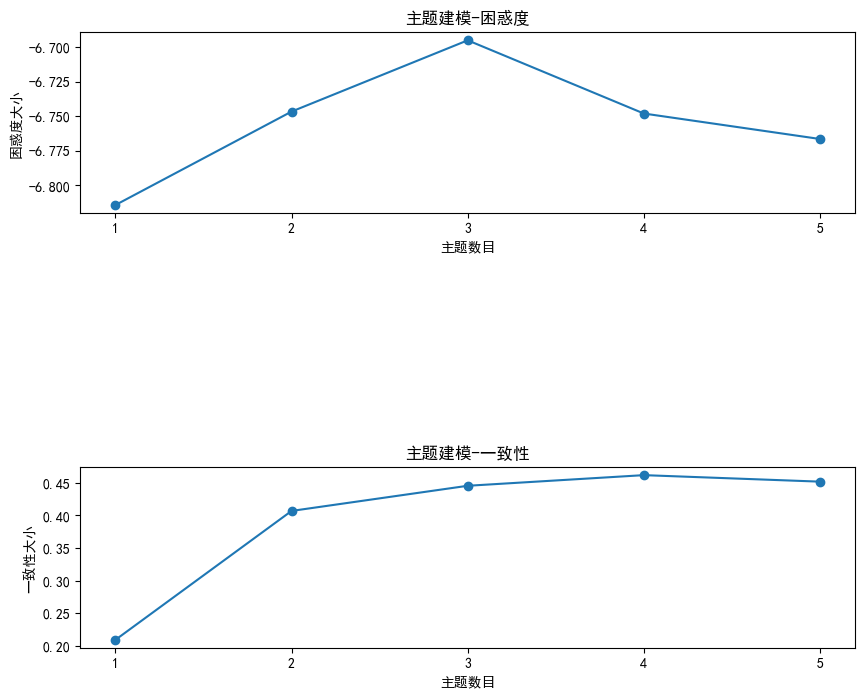

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from pylab import xticks,yticks,np


# 调用准备函数
model_list, x, perplexity_values, coherence_values = lda_model_values(num_topics, corpus, dictionary) 

# 绘制困惑度和一致性折线图
fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False 


ax1 = fig.add_subplot(3, 1, 1)
plt.plot(x, perplexity_values, marker="o")
plt.title("主题建模-困惑度")
plt.xlabel('主题数目')
plt.ylabel('困惑度大小')
xticks(np.linspace(1, num_topics, num_topics, endpoint=True)) # 保证x轴刻度为1

ax2 = fig.add_subplot(3, 1, 3)
plt.plot(x, coherence_values, marker="o")
plt.title("主题建模-一致性")
plt.xlabel("主题数目")
plt.ylabel("一致性大小")
xticks(np.linspace(1, num_topics, num_topics, endpoint=True))


plt.show()